# Linear SVC with SGD

## Import Libraries

In [69]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import scipy.stats
from scipy import stats
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

## Load Data
Preprocessed train (x, y) and test (x) datasets for model training and testing as well as separate x/y train/val datasets for ROC computation.

In [30]:
x_trn = pd.read_pickle("./data/x_train.pkl")
y_trn = pd.read_pickle("./data/y_train.pkl")
x_tst = pd.read_pickle("./data/x_test.pkl")
x_train_roc = pd.read_pickle("./data/x_train_roc.pkl")
y_train_roc = pd.read_pickle("./data/y_train_roc.pkl")
x_val_roc = pd.read_pickle("./data/x_val_roc.pkl")
y_val_roc = pd.read_pickle("./data/y_val_roc.pkl")

## Initialize Model

Set random seed

In [31]:
rng = np.random.RandomState(0)

Create cross-validation generator

In [66]:
# Dataset split into 5 parts (80% | 20% Train/Val)
cvg = StratifiedKFold(n_splits=5, shuffle=False)

Create an instance of the classifier we want to use

In [67]:
# Specify model penalty and loss: l2 used in standard SVC, hinge is the standard SVM loss
clf = SGDClassifier(loss='hinge', penalty='l2', random_state=rng)

## Hyperparameter Tuning

Take a look at the parameters we'll need to create a grid for

In [34]:
clf.get_params(deep=False)

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': RandomState(MT19937) at 0x7FBED0F49640,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Create parameter grid

In [35]:
param_grid = {'alpha':np.logspace(-5,-3,num=20,base=10,dtype='float'),
              'tol':np.logspace(-5,-3,num=20,base=10,dtype='float')}

Create successive halving grid search cross-validation estimator

In [70]:
# Ignore convergence warning messages
simplefilter("ignore", category=ConvergenceWarning)

# Initialize HalvingGridSearch with parameter grid, model,
# and factor = 2 to select half the candidates for subsequent iterations
search = HalvingGridSearchCV(estimator=clf, 
                             param_grid=param_grid, 
                             factor=2,
                             cv=cvg, 
                             random_state=rng)

# Searches over parameter grid with successive halving of x and y train
search.fit(x_trn, y_trn)

# Identify the best model parameters to fit the model on later
print(search.best_estimator_)
print(search.best_params_)

SGDClassifier(alpha=2.6366508987303556e-05,
              random_state=RandomState(MT19937) at 0x7FBBE804C640,
              tol=6.951927961775606e-05)
{'alpha': 2.6366508987303556e-05, 'tol': 6.951927961775606e-05}


## Candidate Score Plot

Plot and save candidate scores over successive halving iterations

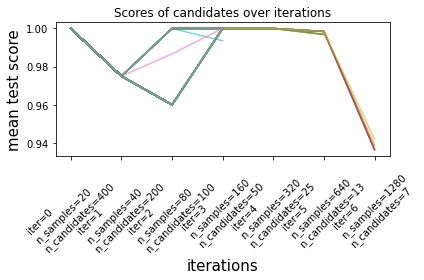

In [78]:
# Initialize variable containing results of HalvingGridSearch
results = pd.DataFrame(search.cv_results_)
# Convert parameters to str
results["params_str"] = results.params.apply(str)
# Remove duplicate results
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
# Get mean test scores
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)

# Create a plot of candidates' scores over multiple iterations
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={search.n_resources_[i]}\nn_candidates={search.n_candidates_[i]}"
    for i in range(search.n_iterations_)
]

ax.set_xticks(range(search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.savefig("./figures/candidate_score_plot_LinearSVC_SGD.png")

## ROC Curve

Plot and save AUROC curve

training score:1.0
validation score:1.0


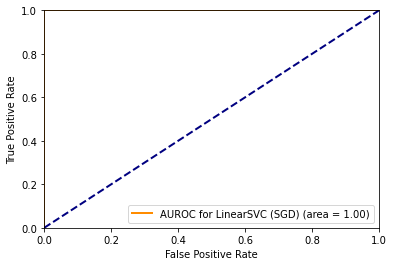

In [76]:
# Train the model on the datasets (train/val) imported for ROC 
clf_roc = SGDClassifier(loss='hinge', penalty='l2', random_state=rng)
# Specify the best parameters from the HalvingGridSearch to fit the model on
clf_roc.set_params(**search.best_params_)
clf_roc.fit(x_train_roc, y_train_roc)
y_pred_roc = clf_roc.predict(x_val_roc)

# Compute the false positive and true positive rate
fpr, tpr, _ = roc_curve(y_val_roc, y_pred_roc, pos_label=1)

# Compute AUROC
roc_auc = auc(fpr, tpr)	

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='AUROC for LinearSVC (SGD) (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig("./figures/roc_curve_LinearSVC_SGD.png")

# Get the training and validation score
print('training score:' + str(clf_roc.score(x_train_roc, y_train_roc)))
print('validation score:' + str(clf_roc.score(x_val_roc,y_val_roc)))

## Fit Model and Predict

Set classifier parameters to optimal values identified by cross-validation and fit on entire training set, then output predictions on test set

In [74]:
# Set parameters of model as the best parameters resulting from the search
clf.set_params(**search.best_params_)
clf.fit(x_trn, y_trn)

# Create and save predictions
y_pred = clf.predict(x_tst)
pickle.dump(y_pred,open("./data/y_pred_LinearSVC_SGD.pkl", "wb"))

print('training score:' + str(clf.score(x_trn, y_trn)))

training score:1.0


## Importance Score Plot

Plot and save feature importance scores to determine top features

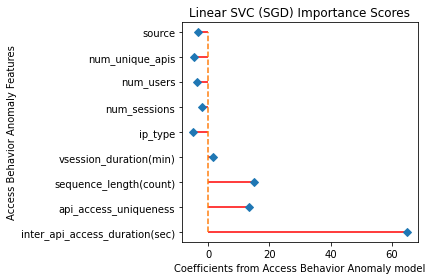

In [75]:
# Get model coefficients as an array
coef = clf.coef_
coef = coef[0,:]
# Get model features
features = x_trn.columns
# Sort the coefficients by their magnitude
arg_rank = np.argsort(-np.abs(coef))
# Get the number of features
used_features = len(features)

# Plot coefficient chart
plt.hlines( np.arange(used_features),0,coef, color='red')
plt.plot(coef, np.arange(used_features), 'D')
plt.plot([0, 0], [np.arange(used_features).min(), np.arange(used_features).max()], '--')
plt.title("Linear SVC (SGD) Importance Scores")
plt.ylabel("Access Behavior Anomaly Features")
plt.xlabel("Coefficients from Access Behavior Anomaly model")
plt.yticks(np.arange(used_features),features)
plt.tight_layout()
plt.savefig("./figures/importance_score_plot_LinearSVC_SGD.png")